This notebook relates to section 4.4.1 of the thesis: 128-by-128-pixel patch-wise segmentation



## Installations

In [ ]:
pip -q install wandb

In [ ]:
pip -q install tensorflow_addons

In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

import wandb
from wandb.keras import WandbCallback

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

Running on TPU  ['10.86.134.170:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.86.134.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.86.134.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

## Functions for loading data in TFRecords format

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([128 * 128], tf.float32),
        "mask_orig_raw": tf.io.FixedLenFeature([128 * 128], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [128, 128, 1])

    mask = example_proto["mask_orig_raw"]
    mask = tf.reshape(mask, [128, 128, 1])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(mask)

    return image, mask

def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [128, 128, 1])

    mask = example_proto["mask_orig_raw"]
    mask = tf.reshape(mask, [128, 128, 1])

    return image, mask

In [ ]:
empty_mean = 69.1 # mean for data centering
empty_std = 71.8 # std for data normalization

non_empty_mean = 89.5 # mean for data centering
non_empty_std = 76.0 # std for data normalization

def normalise(ds):
  # ds = ds.map(lambda img, mask: ((img-empty_mean)/empty_std, mask))
  ds = ds.map(lambda img, mask: (img/255, mask))
  return ds


def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size)
  ds = optimise_dataset(ds)
  return ds

## Load training & validation data from Google Cloud

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

In [ ]:
train_nonempty_gcs_pattern = "gs://tfrecords_patches_train_val_segmentation/train_non_empty*"
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto_aug)
# train_nonempty_ds = train_nonempty_ds.map(gray_2_rgb)

# train_datasets = [train_nonempty_ds.repeat()]
# train_ds = tf.data.experimental.sample_from_datasets(train_datasets, [1])

train_ds = prepare_data(train_nonempty_ds)

In [ ]:
val_nonempty_gcs_pattern = "gs://tfrecords_patches_train_val_segmentation/val_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)
# val_nonempty_ds = val_nonempty_ds.map(gray_2_rgb)

val_ds = prepare_data(val_nonempty_ds)

## Display Images

In [ ]:
def display_img_mask(batch_num, img_num):

  for images, labels in val_ds.take(batch_num):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()

  plt.subplot(1,2,1)
  plt.imshow(numpy_images[img_num].reshape((128,128)))

  plt.subplot(1,2,2)
  plt.imshow(numpy_labels[img_num].reshape(128,128))

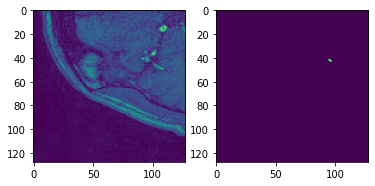

In [ ]:
display_img_mask(55,60)

In [ ]:
# train_ds and valid_ds are unpacked into images and masks for viewing purposes

train_images = list(train_ds.take(1))
train_masks = np.concatenate([img[1] for img in train_images])
train_images = np.concatenate([img[0] for img in train_images])

val_images = list(val_ds.take(1))
val_masks = np.concatenate([img[1] for img in val_images])
val_images = np.concatenate([img[0] for img in val_images])

## Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


  def dice_coef_loss(y_true, y_pred):

    return (1.0 - dice_coef(y_true, y_pred))


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=True)
    dice = dice_coef(y_true, y_pred)

    return bce + (1.0 - dice)

## Model Architecture

### Original U-Net Model

In [ ]:
def build_orig_model(lr=1e-3, initial_bias=0):
    with tpu_strategy.scope():

      inputs = Input((128, 128, 1))
      conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
      conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) # 128 x 128 x 16
      pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 64 x 64 x 16

      conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) 
      conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2) # 64 x 64 x 32
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 32 x 32 x 32

      conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
      conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) # 32 x 32 x 64
      pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16 x 16 x 64

      conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
      conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) # 16 x 16 x 128
      pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # 8 x 8 x 128

      conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
      conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5) # 8 x 8 x 256

      up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) # upsample conv5 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
      conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
      conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6) # 16 x 16 x 128

      up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
      conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
      conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7) # 32 x 32 x 64

      up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
      conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
      conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8) # 64 x 64 x 32

      up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3) # upsample conv8 (128 x 128 x 16) + conv1 (128 x 128 x 16) = 128 x 128 x 32
      conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
      conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9) # 128 x 128 x 16

      conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) # 128 x 128 x 1

      model = Model(inputs=[inputs], outputs=[conv10])
      
      return(model)

### Original U-Net Model with dropout

In [ ]:
def build_orig_model_dropout(lr=1e-3, initial_bias=0):
  with tpu_strategy.scope():

    inputs = Input((128, 128, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) # 128 x 128 x 16
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 64 x 64 x 16
    drop1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop1) 
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2) # 64 x 64 x 32
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 32 x 32 x 32
    drop2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) # 32 x 32 x 64
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16 x 16 x 64
    drop3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) # 16 x 16 x 128
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # 8 x 8 x 128
    drop4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5) # 8 x 8 x 256

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) # upsample conv5 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6) # 16 x 16 x 128

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7) # 32 x 32 x 64

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8) # 64 x 64 x 32

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3) # upsample conv8 (128 x 128 x 16) + conv1 (128 x 128 x 16) = 128 x 128 x 32
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9) # 128 x 128 x 16

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) # 128 x 128 x 1

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

### Original U-Net Model with dropout & l2 regularisation

In [ ]:
from keras.regularizers import l2
# instantiate regularizer
reg = l2(0.001)

In [ ]:
def build_orig_model_l2(lr=1e-3, initial_bias=0):
  with tpu_strategy.scope():

    inputs = Input((128, 128, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv1) # 128 x 128 x 16
    pool1 = MaxPooling2D(pool_size=(2, 2), activity_regularizer=reg)(conv1) # 64 x 64 x 16
    drop1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(drop1) 
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv2) # 64 x 64 x 32
    pool2 = MaxPooling2D(pool_size=(2, 2), activity_regularizer=reg)(conv2) # 32 x 32 x 32
    drop2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(drop2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv3) # 32 x 32 x 64
    pool3 = MaxPooling2D(pool_size=(2, 2), activity_regularizer=reg)(conv3) # 16 x 16 x 64
    drop3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(drop3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv4) # 16 x 16 x 128
    pool4 = MaxPooling2D(pool_size=(2,2), activity_regularizer=reg)(conv4) # 8 x 8 x 128
    drop4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(drop4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv5) # 8 x 8 x 256

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) # upsample conv5 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv6) # 16 x 16 x 128

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv7) # 32 x 32 x 64

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv8) # 64 x 64 x 32

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3) # upsample conv8 (128 x 128 x 16) + conv1 (128 x 128 x 16) = 128 x 128 x 32
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=reg)(conv9) # 128 x 128 x 16

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) # 128 x 128 x 1

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

### UNet 1

In [ ]:
def build_model(lr=1e-3, initial_bias=0):
    with tpu_strategy.scope():
        inputs = Input((128, 128, 1))
        conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) # 128 x 128 x 16
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 64 x 64 x 16
        drop1 = Dropout(0.2)(pool1)

        conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop1) 
        conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2) # 64 x 64 x 32
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 32 x 32 x 32
        drop2 = Dropout(0.2)(pool2)

        conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop2)
        conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) # 32 x 32 x 64
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16 x 16 x 64
        drop3 = Dropout(0.2)(pool3)

        conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
        conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) # 16 x 16 x 128
        pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # 8 x 8 x 128
        drop4 = Dropout(0.2)(pool4)

        conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop4)
        conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5) # 8 x 8 x 256

        up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) # upsample conv5 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
        conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
        conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6) # 16 x 16 x 128

        up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
        conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
        conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7) # 32 x 32 x 64

        up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
        conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
        conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8) # 64 x 64 x 32

        up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3) # upsample conv8 (128 x 128 x 16) + conv1 (128 x 128 x 16) = 128 x 128 x 32
        conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
        conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9) # 128 x 128 x 16

        bias_initializer = tf.keras.initializers.Constant(initial_bias)
        conv10 = Conv2D(1, (1, 1), activation='sigmoid', bias_initializer=bias_initializer)(conv9) # 128 x 128 x 1

        model = Model(inputs=[inputs], outputs=[conv10])
        return model

### UNet 2 (added complexity)

In [ ]:
def build_model(lr=1e-3, initial_bias=0):
    with tpu_strategy.scope():
        inputs = Input((128, 128, 1))
        conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) # 128 x 128 x 16
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 64 x 64 x 16
        drop1 = Dropout(0.2)(pool1)

        conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop1) 
        conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2) # 64 x 64 x 32
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 32 x 32 x 32
        drop2 = Dropout(0.2)(pool2)

        conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop2)
        conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) # 32 x 32 x 64
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16 x 16 x 64
        drop3 = Dropout(0.2)(pool3)

        conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
        conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) # 16 x 16 x 128
        pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # 8 x 8 x 128
        drop4 = Dropout(0.2)(pool4)

        conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop4)
        conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5) # 8 x 8 x 256
        pool5 = MaxPooling2D(pool_size=(2,2))(conv5) # 4 x 4 x 256
        drop5 = Dropout(0.2)(pool5)

        conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop5)
        conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6) # 4 x 4 x 512

        up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3) # upsample conv6 (8 x 8 x 256) + conv5 (8 x 8 x 256) = 8 x 8 x 512
        conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
        conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7) # 8 x 8 x 256

        up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3) # upsample conv6 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
        conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
        conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8) # 16 x 16 x 128

        up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
        conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
        conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9) # 32 x 32 x 64

        up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
        conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up10)
        conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10) # 64 x 64 x 32

        up11 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3) # upsample conv8 (128 x 128 x 16) + conv1 (128 x 128 x 16) = 128 x 128 x 32
        conv11 = Conv2D(16, (3, 3), activation='relu', padding='same')(up11)
        conv11 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv11) # 128 x 128 x 16

        bias_initializer=tf.keras.initializers.Constant(inital_bias)
        conv12 = Conv2D(1, (1, 1), activation='sigmoid', bias_initializer=bias_initializer)(conv11) # 128 x 128 x 1

        model = Model(inputs=[inputs], outputs=[conv12])
        model.compile(optimizer=Adam(learning_rate=lr), loss=dice_coef_loss, metrics=metrics)
        return model

### UNet 3 (smaller)

In [ ]:
def build_model_small(lr=1e-3, initial_bias=0):
    with tpu_strategy.scope():
        inputs = Input((128, 128, 1))
        conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1) # 128 x 128 x 16
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 64 x 64 x 16
        drop1 = Dropout(0.1)(pool1)

        conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(drop1) 
        conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2) # 64 x 64 x 32
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 32 x 32 x 32
        drop2 = Dropout(0.1)(pool2)

        conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop2)
        conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3) # 32 x 32 x 64
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16 x 16 x 64
        drop3 = Dropout(0.1)(pool3)

        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop3)
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4) # 16 x 16 x 128

        up5 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3) # upsample conv5 (16 x 16 x 128) + conv4 (16 x 16 x 128) = 16 x 16 x 256
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5) # 32 x 32 x 256

        up6 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3) # upsample conv6 (32 x 32 x 64) + conv3 (32 x 32 x 64) = 32 x 32 x 128
        conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up6)
        conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6) # 64 x 64 x 128

        up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3) # upsample conv7 (64 x 64 x 32) + conv2 (64 x 64 x 32) = 64 x 64 x 64
        conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(up7)
        conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv7) # 128 x 128 x 64

        bias_initializer=tf.keras.initializers.Constant(initial_bias)
        conv8 = Conv2D(1, (1, 1), activation='sigmoid', bias_initializer=bias_initializer)(conv7) # 128 x 128 x 1

        model = Model(inputs=[inputs], outputs=[conv8])

        return model

## Single-batch training

In [ ]:
with tpu_strategy.scope():

  model = build_model(lr=1e-3)
  model.fit(train_ds.take(1), epochs=200)

Epoch 1/200
1/1 [==============================] - 14s 14s/step - loss: -0.0019 - dice_coef: 0.0019
Epoch 2/200
1/1 [==============================] - 0s 406ms/step - loss: -0.0020 - dice_coef: 0.0020
Epoch 3/200
1/1 [==============================] - 0s 264ms/step - loss: -0.0018 - dice_coef: 0.0018
Epoch 4/200
1/1 [==============================] - 0s 208ms/step - loss: -0.0020 - dice_coef: 0.0020
Epoch 5/200
1/1 [==============================] - 0s 216ms/step - loss: -0.0020 - dice_coef: 0.0020
Epoch 6/200
1/1 [==============================] - 0s 223ms/step - loss: -0.0026 - dice_coef: 0.0026
Epoch 7/200
1/1 [==============================] - 0s 244ms/step - loss: -0.0023 - dice_coef: 0.0023
Epoch 8/200
1/1 [==============================] - 0s 222ms/step - loss: -0.0028 - dice_coef: 0.0028
Epoch 9/200
1/1 [==============================] - 0s 355ms/step - loss: -0.0033 - dice_coef: 0.0033
Epoch 10/200
1/1 [==============================] - 0s 223ms/step - loss: -0.0023 - dice_coe

In [ ]:
model.get_weights()[-1]

array([-6.020684], dtype=float32)

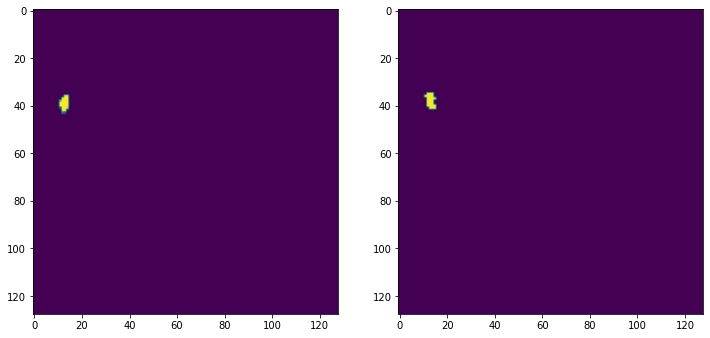

In [ ]:
def min_max_scale(img):
    img = tf.squeeze(img)
    max_val = tf.reduce_max(img)
    min_val = tf.reduce_min(img)
    return (img - min_val)/(max_val-min_val)
    
preds = model.predict(imgs)
fig, axes = plt.subplots(ncols=2, figsize=(12,12))
index = 1
axes[0].imshow(min_max_scale(preds[index]))
axes[1].imshow(tf.squeeze(labels[index]))

In [ ]:
output_bias = 0.0025177002
tf.reduce_mean(tf.cast(labels,tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0025177002>

In [ ]:
output_bias = 0.0025177002
inital_bias = -np.log((1/output_bias) - 1)
inital_bias

-5.981888538259768

## Learning rate scheduler & early stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-3,
          lr_max=1e-1,
          lr_min=1e-5,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )


In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

class OneCycleLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        lr = self.clr()
        print(lr)
        K.set_value(self.model.optimizer.lr, lr)
        
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True,
                    mode='auto')

# Training variations of original model

In [ ]:
with tpu_strategy.scope():

  lr = 10**(-2)
  loss = tf.keras.losses.binary_crossentropy # mixed_loss # dice_coef_loss # tf.keras.losses.binary_crossentropy
  # loss = tfa.losses.SigmoidFocalCrossEntropy()
  metrics = dice_coef

  model = build_model_small(lr=lr, initial_bias=0)

  model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)

  print('Creating and compiling model...')

  print('Fitting model...')
  # history=model.fit(
  #       train_ds,
  #       epochs=50, 
  #       validation_data=val_ds, callbacks=[early_stopping]) # tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1)])

  history = model.fit(
      train_ds.repeat(),
      epochs=100, 
      steps_per_epoch=5, 
      validation_data=val_ds.repeat(), 
      validation_steps=10) 
      # callbacks=[]#, tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1)], early_stopping, ]



Creating and compiling model...
Fitting model...
Epoch 1/100
5/5 [==============================] - 22s 2s/step - loss: 0.5834 - dice_coef: 0.0035 - val_loss: 0.0436 - val_dice_coef: 4.5606e-04
Epoch 2/100
5/5 [==============================] - 2s 385ms/step - loss: 0.0489 - dice_coef: 0.0012 - val_loss: 0.0116 - val_dice_coef: 0.0031
Epoch 3/100
5/5 [==============================] - 1s 331ms/step - loss: 0.0158 - dice_coef: 0.0031 - val_loss: 0.0091 - val_dice_coef: 0.0027
Epoch 4/100
5/5 [==============================] - 1s 327ms/step - loss: 0.0152 - dice_coef: 0.0025 - val_loss: 0.0085 - val_dice_coef: 0.0026
Epoch 5/100
5/5 [==============================] - 1s 328ms/step - loss: 0.0145 - dice_coef: 0.0024 - val_loss: 0.0085 - val_dice_coef: 0.0026
Epoch 6/100
5/5 [==============================] - 2s 366ms/step - loss: 0.0144 - dice_coef: 0.0022 - val_loss: 0.0088 - val_dice_coef: 0.0023
Epoch 7/100
5/5 [==============================] - 1s 332ms/step - loss: 0.0133 - dice_coef

KeyboardInterrupt: ignored

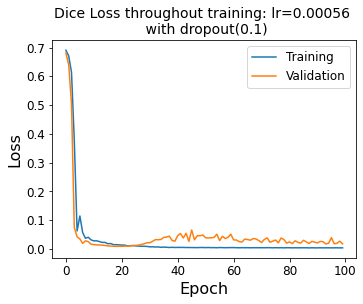

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Dice Loss throughout training: lr={} \n with dropout(0.1)'.format(np.round(lr,5)), size=14)
plt.legend(prop={'size': 12})

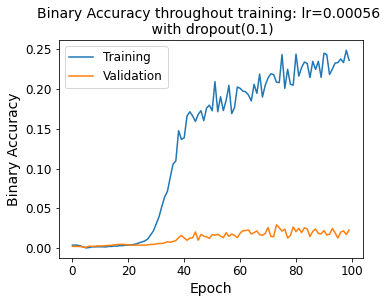

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='Training')
plt.plot(history.history['val_dice_coef'], label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Binary Accuracy', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Binary Accuracy throughout training: lr={} \n with dropout(0.1)'.format(np.round(lr,5)), size=14)
plt.legend(prop={'size': 12})

# Find optimal LR

In [ ]:
loss = tf.keras.losses.binary_crossentropy
metrics = dice_coef

model = build_model_small()
model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

initial_weights = model.get_weights()
len(initial_weights)

36

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-5, -1, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    for rate in tqdm(rates):

          model.compile(optimizer=Adam(learning_rate=rate), loss=loss, metrics=metrics)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=5, verbose=0)
          losses.append(model.history.history['loss'][-1])
    return losses, rates

losses, rates = find_learning_rate(50)

  0%|          | 0/50 [00:00<?, ?it/s]

### MIXED

(array([0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]),
 <a list of 10 Text major ticklabel objects>)

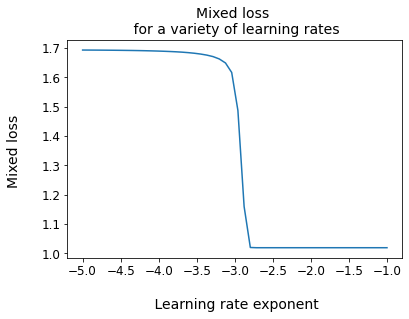

In [ ]:
# corrected

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Mixed loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Mixed loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

### FOCAL

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14]),
 <a list of 8 Text major ticklabel objects>)

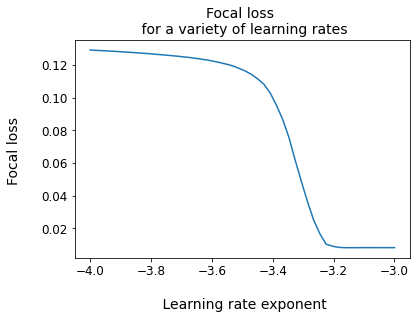

In [ ]:
# corrected

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Focal loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Focal loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

### DICE

(array([0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999,
        1.   , 1.001]), <a list of 11 Text major ticklabel objects>)

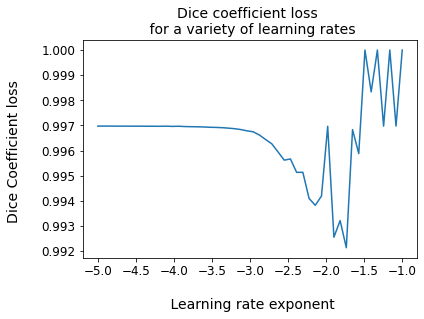

In [ ]:
# corrected

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Dice coefficient loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Dice Coefficient loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

### BCE

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]), <a list of 11 Text major ticklabel objects>)

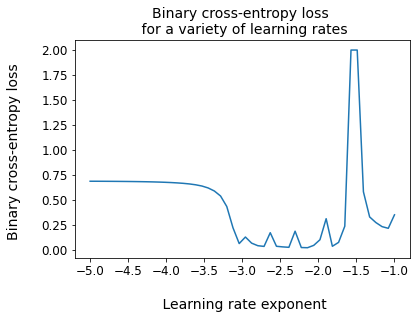

In [ ]:
# orig model

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]), <a list of 11 Text major ticklabel objects>)

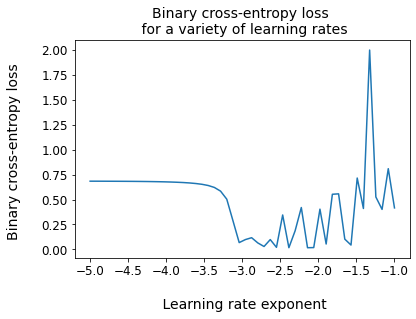

In [ ]:
# orig model with dropout

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]), <a list of 11 Text major ticklabel objects>)

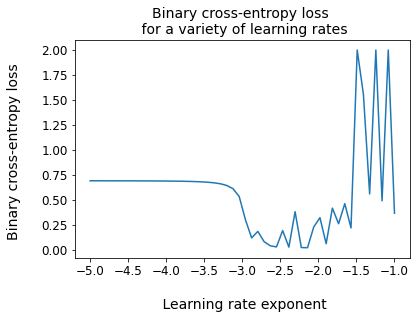

In [ ]:
# orig model with dropout & AdamW (changed from Adam)

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2]),
 <a list of 10 Text major ticklabel objects>)

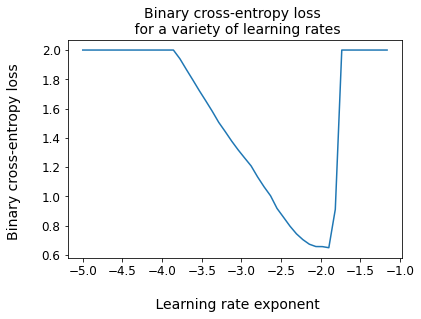

In [ ]:
# orig model with dropout & l2(0.001) (AdamW changed back to Adam)

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text major ticklabel objects>)

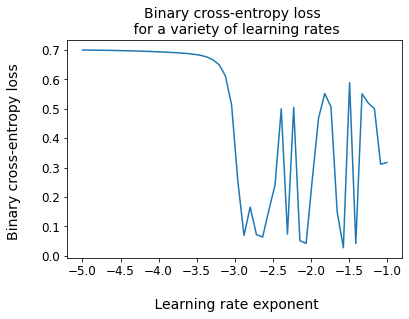

In [ ]:
# UNet 3 (small model), with dropout(0.2)

plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

# Testing

### Load test data in TFRecords format

In [ ]:
print('Loading and preprocessing test data (non-empty masks)...')

test_non_empty_gcs_pattern = "gs://tfrecords_patches_test_segmentation/test_non_empty*"
test_non_empty_filenames = tf.io.gfile.glob(test_non_empty_gcs_pattern)
test_non_empty_ds = tf.data.TFRecordDataset(test_non_empty_filenames)

test_non_empty_ds = test_non_empty_ds.map(_parse_image_function)
test_non_empty_ds = test_non_empty_ds.map(_unpack_proto)
# test_non_empty_ds = test_non_empty_ds.map(gray_2_rgb)

test_ds = prepare_data(test_non_empty_ds)

Loading and preprocessing test data (non-empty masks)...


In [ ]:
test_pairs = list(test_ds.take(1))

test_images = [pair[0] for pair in test_pairs]
test_images_to_display = np.concatenate(test_images)

test_masks_orig = [pair[1] for pair in test_pairs]
test_masks_orig = np.concatenate(test_masks_orig)

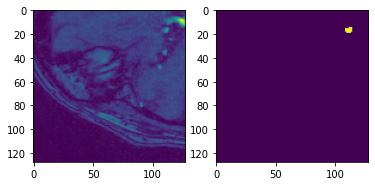

In [ ]:
img_num = 34 # imgs 10, 34 don't match mask

plt.subplot(1,2,1)
plt.imshow(test_images_to_display[img_num].reshape((128,128)))

plt.subplot(1,2,2)
plt.imshow(test_masks_orig[img_num].reshape((128,128)))

In [ ]:
def compare_img_mask(img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.figure(figsize=(20, 4)) 

  plt.subplot(1,3,1)
  plt.imshow(test_images_to_display[img_num].reshape((128,128)))
  plt.title('Original image patch')

  plt.subplot(1,3,2)
  plt.imshow(test_masks_orig[img_num].reshape((128,128)))
  plt.title('True mask')

  plt.subplot(1,3,3)
  plt.imshow(test_preds[img_num].reshape((128,128)))
  plt.title('Predicted mask')

### Predict on test data

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(img) for img in test_images]
test_preds = np.concatenate(test_preds)

Predicting masks on test data...


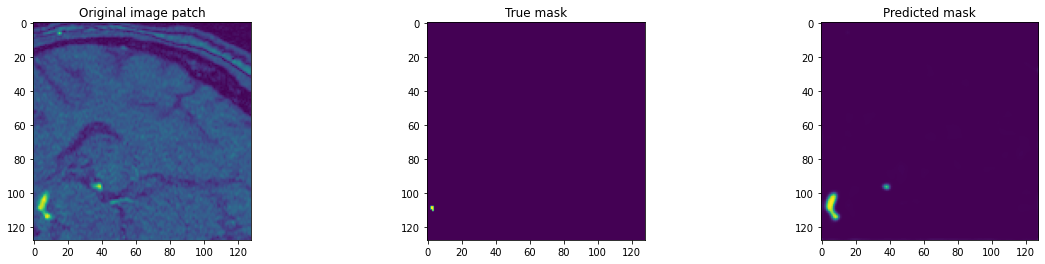

In [ ]:
compare_img_mask(30)

### Calculate Dice coefficient on test set

In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(test_masks_orig)):
  true_mask = test_masks_orig[i]
  pred_mask = test_preds[i].reshape((128,128))
  pred_mask = np.round(pred_mask)

  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

np.mean(dice_coeff_list), np.std(dice_coeff_list)

(0.07195568, 0.12620395)

(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 7 Text major ticklabel objects>)

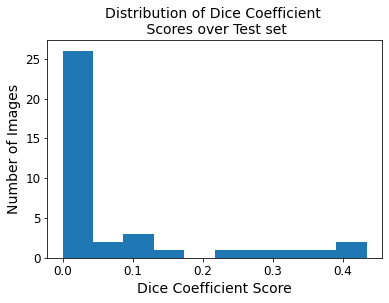

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient \n Scores over Test set', size=14)
plt.xlabel('Dice Coefficient Score', size=14)
plt.ylabel('Number of Images', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
high = []

for key,val in dice_coeff_dict.items():
  if val<0.1:
    low.append(key)
  elif val>0.5:
    high.append(key)

len(low), len(high)

(26, 7)

In [ ]:
high # images with dice score over 0.5

# image 8 scored highly for runs: 8.0, 8.1
# image 33 scored highly for runs: 8.1

[6, 11, 13, 15, 22, 26, 27]

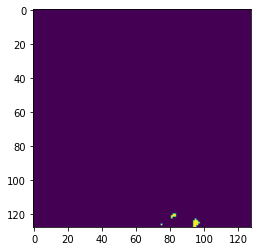

In [ ]:
plt.imshow(np.where(test_preds[6]>0.5,1,0).reshape((128,128)))

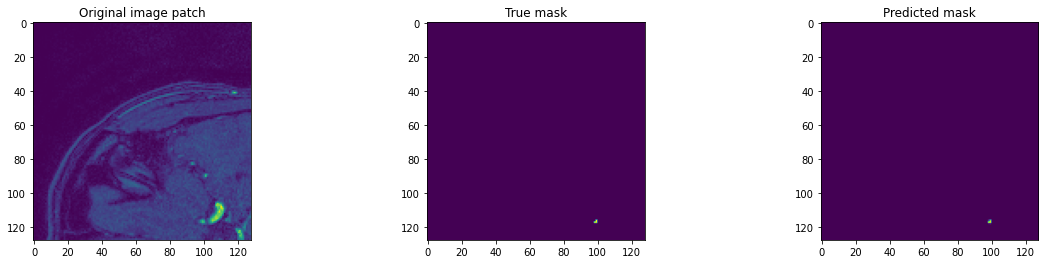

In [ ]:
compare_img_mask(27)